# Détection de la position d'un usager par apprentissage artificielle

In [5]:
from src.plot import openImage
from src.plot import plot_position
import matplotlib.pyplot as plt

Plan du batiment

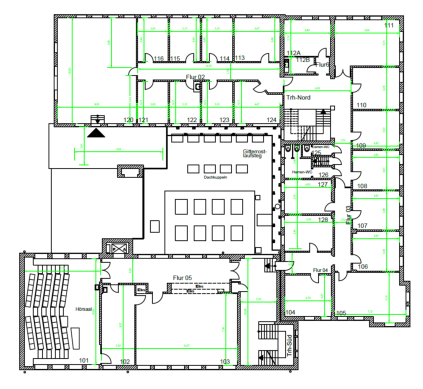

In [6]:
ECHELLE = 100
image_batiment = openImage("./images/batiment.png")

plt.imshow(image_batiment)
plt.axis("off")
plt.show()

#### Chargement des signaux collectés par position

In [7]:
from src.load import load_collected_positions_2d
P, D = load_collected_positions_2d("./datas/without_acces/BSSIDs_collected.csv")

Visualisation des positions où les signaux ont été collectés

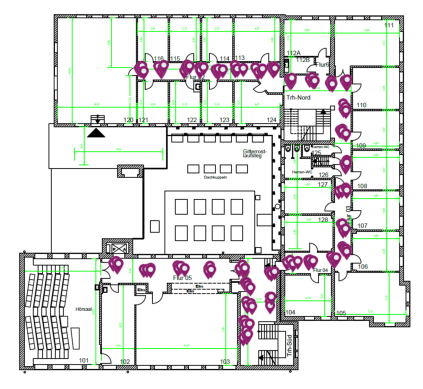

In [8]:
image = openImage("./images/batiment.png")
for M in P:
    image = plot_position(
        M,
        None,
        "./images/pointeur_violet.png",
        image=image,
        echelle=ECHELLE,
        showed=False,
    )

plt.imshow(image)
plt.axis("off")
plt.show()

#### Pretraitement des groupes de signaux

* Transformation des groupes de signaux en vecteur avec `DictVectorizer`
* Normalisation des vecteurs obtenus en utilisant `StandardScaler`

In [9]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

preModel = Pipeline(
    [("DicVect", DictVectorizer(sparse=False)), ("Scaler", StandardScaler())]
)
datas = preModel.fit_transform(D)
datas.shape

(128, 110)

#### Construction et choix du modèle a utilisé

Il est important que le modèle :
* Soit explicable
* Possède une inférence de complexité linéaire

##### Modèles utilisables

In [10]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor


def DecisionTree():
    return DecisionTreeRegressor()

def KNN():
    return KNeighborsRegressor()

def XGBoost():
    return XGBRegressor()


def CatBoost():
    return MultiOutputRegressor(CatBoostRegressor())


regressors = {
    "KNN": KNN,
    "DecisionTree": DecisionTree,
    "XGBoost": XGBoost,
    "CatBoost": CatBoost,
}

##### Evaluation des modèles utilisables sur la datset (`Cross Validation`)

Metriques d'évaluation

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)


def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)


def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)
    
metrics = {
    "rmse": rmse,
    "mse": mse,
    "mae": mae,
    "r2": r2_score
}

is_best_greatest = {
    "rmse": False,
    "mse": False,
    "mae": False,
    "r2": True,
}

Evaluation des modèles proprement dit

In [12]:
from sklearn.model_selection import KFold
from numpy import mean
from pandas import DataFrame

kf = KFold(n_splits=10, shuffle=True, random_state=42)

perfs = {
    name_model: {name_metric: [] for name_metric in metrics.keys()}
    for name_model in regressors.keys()
}

for train_index, test_index in kf.split(datas):
    X_train, X_test = datas[train_index], datas[test_index]
    y_train, y_test = P[train_index], P[test_index]

    for name_model in regressors.keys():
        regressor = regressors[name_model]()
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        for name_metric in metrics.keys():
            metric = metrics[name_metric](y_test, y_pred)
            perfs[name_model][name_metric].append(metric)

pfs = []
for name_model in regressors.keys():
    perf_model = {"model": name_model}
    for name_metric in metrics.keys():
        perf_model[name_metric] = round(mean(perfs[name_model][name_metric]),3)
    pfs.append(perf_model)

df = DataFrame(pfs).set_index("model")

for name_metric in df.columns:
    if not is_best_greatest[name_metric]:
        df[name_metric] = df[name_metric].apply(lambda x: -x)

df = df.sort_values([name_metric for name_metric in metrics], ascending=False)

for name_metric in df.columns:
    if not is_best_greatest[name_metric]:
        df[name_metric] = df[name_metric].apply(lambda x: -x)


/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Learning rate set to 0.029092
0:	learn: 1.6948081	total: 49.9ms	remaining: 49.9s
1:	learn: 1.6650488	total: 51.4ms	remaining: 25.7s
2:	learn: 1.6374125	total: 52.7ms	remaining: 17.5s
3:	learn: 1.6100680	total: 54.4ms	remaining: 13.6s
4:	learn: 1.5819745	total: 56.6ms	remaining: 11.3s
5:	learn: 1.5514024	total: 57.4ms	remaining: 9.51s
6:	learn: 1.5226711	total: 58.7ms	remaining: 8.32s
7:	learn: 1.4979463	total: 60.1ms	remaining: 7.46s
8:	learn: 1.4699275	total: 61.5ms	remaining: 6.77s
9:	learn: 1.4419839	total: 63.8ms	remaining: 6.32s
10:	learn: 1.4163228	total: 65.4ms	remaining: 5.88s
11:	learn: 1.3921983	total: 66.9ms	remaining: 5.5s
12:	learn: 1.3699533	total: 68.5ms	remaining: 5.2s
13:	learn: 1.3440609	total: 70.5ms	remaining: 4.97s
14:	learn: 1.3210103	total: 73.2ms	remaining: 4.81s
15:	learn: 1.2992849	total: 75.1ms	remaining: 4.62s
16:	learn: 1.2762280	total: 77.1ms	remaining: 4.46s
17:	learn: 1.2486691	total: 78.8ms	remaining: 4.3s
18:	learn: 1.2289146	total: 80.3ms	remaining: 4

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.6157584	total: 5.29ms	remaining: 5.28s
1:	learn: 1.5851172	total: 8.49ms	remaining: 4.23s
2:	learn: 1.5598552	total: 11.8ms	remaining: 3.92s
3:	learn: 1.5346422	total: 14.5ms	remaining: 3.62s
4:	learn: 1.5108233	total: 17.3ms	remaining: 3.44s
5:	learn: 1.4829080	total: 19.2ms	remaining: 3.18s
6:	learn: 1.4577559	total: 23.4ms	remaining: 3.31s
7:	learn: 1.4350257	total: 26.3ms	remaining: 3.26s
8:	learn: 1.4092525	total: 29.5ms	remaining: 3.25s
9:	learn: 1.3875084	total: 32.3ms	remaining: 3.19s
10:	learn: 1.3651242	total: 35.4ms	remaining: 3.18s
11:	learn: 1.3434958	total: 39.5ms	remaining: 3.25s
12:	learn: 1.3212743	total: 43.1ms	remaining: 3.27s
13:	learn: 1.2962190	total: 46.4ms	remaining: 3.27s
14:	learn: 1.2703596	total: 49.8ms	remaining: 3.27s
15:	learn: 1.2500837	total: 53.7ms	remaining: 3.3s
16:	learn: 1.2288741	total: 57.2ms	remaining: 3.31s
17:	learn: 1.2066862	total: 60.3ms	remaining: 3.29s
18:	learn: 1.1857945	total: 63.2ms	remaining:

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.6428829	total: 4.56ms	remaining: 4.55s
1:	learn: 1.6141973	total: 6.15ms	remaining: 3.07s
2:	learn: 1.5855124	total: 7.99ms	remaining: 2.65s
3:	learn: 1.5592206	total: 10ms	remaining: 2.49s
4:	learn: 1.5340922	total: 11.4ms	remaining: 2.26s
5:	learn: 1.5047336	total: 12.2ms	remaining: 2.02s
6:	learn: 1.4797765	total: 13.6ms	remaining: 1.93s
7:	learn: 1.4556639	total: 15ms	remaining: 1.85s
8:	learn: 1.4294643	total: 16.5ms	remaining: 1.82s
9:	learn: 1.4091287	total: 18.1ms	remaining: 1.79s
10:	learn: 1.3868838	total: 19.5ms	remaining: 1.75s
11:	learn: 1.3631191	total: 22.6ms	remaining: 1.86s
12:	learn: 1.3395624	total: 26.2ms	remaining: 1.99s
13:	learn: 1.3138373	total: 28.6ms	remaining: 2.01s
14:	learn: 1.2896931	total: 30.4ms	remaining: 2s
15:	learn: 1.2679822	total: 31.7ms	remaining: 1.95s
16:	learn: 1.2465511	total: 33ms	remaining: 1.91s
17:	learn: 1.2199889	total: 34.4ms	remaining: 1.88s
18:	learn: 1.2008348	total: 36.2ms	remaining: 1.87s
1

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.6670878	total: 4.82ms	remaining: 4.81s
1:	learn: 1.6333936	total: 8.6ms	remaining: 4.29s
2:	learn: 1.6064505	total: 12.4ms	remaining: 4.13s
3:	learn: 1.5782144	total: 16.9ms	remaining: 4.21s
4:	learn: 1.5524467	total: 19.8ms	remaining: 3.94s
5:	learn: 1.5222246	total: 22.3ms	remaining: 3.69s
6:	learn: 1.4963575	total: 27.8ms	remaining: 3.94s
7:	learn: 1.4722631	total: 31.7ms	remaining: 3.93s
8:	learn: 1.4454738	total: 35ms	remaining: 3.85s
9:	learn: 1.4238817	total: 37.6ms	remaining: 3.72s
10:	learn: 1.4000581	total: 40.9ms	remaining: 3.67s
11:	learn: 1.3766653	total: 45.4ms	remaining: 3.74s
12:	learn: 1.3529651	total: 49.1ms	remaining: 3.73s
13:	learn: 1.3266697	total: 51.8ms	remaining: 3.65s
14:	learn: 1.3019023	total: 57ms	remaining: 3.74s
15:	learn: 1.2810643	total: 60.1ms	remaining: 3.69s
16:	learn: 1.2589142	total: 63.1ms	remaining: 3.65s
17:	learn: 1.2366827	total: 66.3ms	remaining: 3.62s
18:	learn: 1.2145049	total: 69.3ms	remaining: 3.5

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.6797828	total: 2.27ms	remaining: 2.27s
1:	learn: 1.6472787	total: 3.78ms	remaining: 1.88s
2:	learn: 1.6178973	total: 4.99ms	remaining: 1.66s
3:	learn: 1.5904936	total: 6.71ms	remaining: 1.67s
4:	learn: 1.5624631	total: 7.87ms	remaining: 1.57s
5:	learn: 1.5322372	total: 8.66ms	remaining: 1.43s
6:	learn: 1.5070472	total: 10.7ms	remaining: 1.52s
7:	learn: 1.4823128	total: 12.3ms	remaining: 1.52s
8:	learn: 1.4549497	total: 13.6ms	remaining: 1.5s
9:	learn: 1.4302966	total: 15ms	remaining: 1.48s
10:	learn: 1.4060778	total: 16.2ms	remaining: 1.46s
11:	learn: 1.3835390	total: 17.5ms	remaining: 1.44s
12:	learn: 1.3615875	total: 18.7ms	remaining: 1.42s
13:	learn: 1.3353215	total: 19.9ms	remaining: 1.41s
14:	learn: 1.3067119	total: 21.6ms	remaining: 1.42s
15:	learn: 1.2849266	total: 22.9ms	remaining: 1.41s
16:	learn: 1.2623167	total: 25.7ms	remaining: 1.49s
17:	learn: 1.2379173	total: 27ms	remaining: 1.48s
18:	learn: 1.2162747	total: 28.2ms	remaining: 1.4

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.6009174	total: 4.87ms	remaining: 4.87s
1:	learn: 1.5717563	total: 23ms	remaining: 11.5s
2:	learn: 1.5437060	total: 24.5ms	remaining: 8.13s
3:	learn: 1.5167435	total: 25.9ms	remaining: 6.45s
4:	learn: 1.4927593	total: 27.5ms	remaining: 5.47s
5:	learn: 1.4646842	total: 28.4ms	remaining: 4.7s
6:	learn: 1.4410934	total: 29.7ms	remaining: 4.21s
7:	learn: 1.4178393	total: 31.6ms	remaining: 3.92s
8:	learn: 1.3918852	total: 33.2ms	remaining: 3.66s
9:	learn: 1.3702781	total: 35.1ms	remaining: 3.47s
10:	learn: 1.3492311	total: 36.6ms	remaining: 3.29s
11:	learn: 1.3259344	total: 37.8ms	remaining: 3.11s
12:	learn: 1.3034310	total: 39.1ms	remaining: 2.97s
13:	learn: 1.2790582	total: 42ms	remaining: 2.96s
14:	learn: 1.2582004	total: 45.4ms	remaining: 2.98s
15:	learn: 1.2382723	total: 46.8ms	remaining: 2.88s
16:	learn: 1.2177206	total: 48ms	remaining: 2.77s
17:	learn: 1.1943687	total: 50.5ms	remaining: 2.75s
18:	learn: 1.1764068	total: 52.3ms	remaining: 2.7s


/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.6558784	total: 5.33ms	remaining: 5.32s
1:	learn: 1.6242012	total: 9.08ms	remaining: 4.53s
2:	learn: 1.5967605	total: 12.4ms	remaining: 4.11s
3:	learn: 1.5704187	total: 15.4ms	remaining: 3.83s
4:	learn: 1.5464579	total: 18.4ms	remaining: 3.67s
5:	learn: 1.5164043	total: 21.7ms	remaining: 3.59s
6:	learn: 1.4912132	total: 24.8ms	remaining: 3.51s
7:	learn: 1.4664402	total: 27.6ms	remaining: 3.42s
8:	learn: 1.4400319	total: 30.1ms	remaining: 3.32s
9:	learn: 1.4175326	total: 33ms	remaining: 3.27s
10:	learn: 1.3949246	total: 36.1ms	remaining: 3.25s
11:	learn: 1.3746540	total: 39.1ms	remaining: 3.21s
12:	learn: 1.3511455	total: 42ms	remaining: 3.19s
13:	learn: 1.3257931	total: 44.8ms	remaining: 3.15s
14:	learn: 1.3027990	total: 48.1ms	remaining: 3.16s
15:	learn: 1.2822222	total: 51.2ms	remaining: 3.15s
16:	learn: 1.2598714	total: 54.1ms	remaining: 3.13s
17:	learn: 1.2356110	total: 56.6ms	remaining: 3.09s
18:	learn: 1.2138445	total: 59.1ms	remaining: 3.

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029092
0:	learn: 1.7003328	total: 2.73ms	remaining: 2.73s
1:	learn: 1.6672366	total: 3.93ms	remaining: 1.96s
2:	learn: 1.6356590	total: 5.04ms	remaining: 1.68s
3:	learn: 1.6079542	total: 6.11ms	remaining: 1.52s
4:	learn: 1.5815542	total: 9.61ms	remaining: 1.91s
5:	learn: 1.5499917	total: 11.7ms	remaining: 1.94s
6:	learn: 1.5223860	total: 14.8ms	remaining: 2.1s
7:	learn: 1.4976733	total: 18.5ms	remaining: 2.3s
8:	learn: 1.4697316	total: 21.3ms	remaining: 2.34s
9:	learn: 1.4449389	total: 24.1ms	remaining: 2.38s
10:	learn: 1.4220561	total: 27ms	remaining: 2.43s
11:	learn: 1.3979202	total: 31.6ms	remaining: 2.6s
12:	learn: 1.3754412	total: 35.2ms	remaining: 2.67s
13:	learn: 1.3494525	total: 37.9ms	remaining: 2.67s
14:	learn: 1.3238470	total: 40.8ms	remaining: 2.68s
15:	learn: 1.3017683	total: 44ms	remaining: 2.71s
16:	learn: 1.2759730	total: 48ms	remaining: 2.77s
17:	learn: 1.2506910	total: 51.6ms	remaining: 2.82s
18:	learn: 1.2326090	total: 54.4ms	remaining: 2.81s
1

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029132
0:	learn: 1.6045172	total: 2.63ms	remaining: 2.63s
1:	learn: 1.5746730	total: 4.02ms	remaining: 2.01s
2:	learn: 1.5464862	total: 5.57ms	remaining: 1.85s
3:	learn: 1.5230471	total: 6.88ms	remaining: 1.71s
4:	learn: 1.5024650	total: 9.22ms	remaining: 1.83s
5:	learn: 1.4746020	total: 11ms	remaining: 1.82s
6:	learn: 1.4491615	total: 13.8ms	remaining: 1.96s
7:	learn: 1.4252518	total: 17.1ms	remaining: 2.12s
8:	learn: 1.3986127	total: 20.2ms	remaining: 2.23s
9:	learn: 1.3771474	total: 23.7ms	remaining: 2.35s
10:	learn: 1.3536966	total: 27.7ms	remaining: 2.49s
11:	learn: 1.3296816	total: 31.5ms	remaining: 2.59s
12:	learn: 1.3091172	total: 34.4ms	remaining: 2.61s
13:	learn: 1.2861061	total: 37.7ms	remaining: 2.65s
14:	learn: 1.2633420	total: 41ms	remaining: 2.69s
15:	learn: 1.2433615	total: 44.3ms	remaining: 2.73s
16:	learn: 1.2222563	total: 47.8ms	remaining: 2.77s
17:	learn: 1.1987754	total: 50.7ms	remaining: 2.77s
18:	learn: 1.1809419	total: 53.8ms	remaining: 2.

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean

Learning rate set to 0.029132
0:	learn: 1.6687340	total: 4.63ms	remaining: 4.63s
1:	learn: 1.6399152	total: 7.95ms	remaining: 3.96s
2:	learn: 1.6122155	total: 11.1ms	remaining: 3.68s
3:	learn: 1.5855915	total: 13.8ms	remaining: 3.43s
4:	learn: 1.5601146	total: 18.8ms	remaining: 3.75s
5:	learn: 1.5302277	total: 21.2ms	remaining: 3.52s
6:	learn: 1.5056785	total: 24.1ms	remaining: 3.42s
7:	learn: 1.4814756	total: 26.9ms	remaining: 3.34s
8:	learn: 1.4543703	total: 29.9ms	remaining: 3.29s
9:	learn: 1.4325196	total: 32.9ms	remaining: 3.26s
10:	learn: 1.4085030	total: 41.4ms	remaining: 3.72s
11:	learn: 1.3856261	total: 44ms	remaining: 3.63s
12:	learn: 1.3642939	total: 47ms	remaining: 3.57s
13:	learn: 1.3380658	total: 49.9ms	remaining: 3.51s
14:	learn: 1.3145701	total: 53.1ms	remaining: 3.49s
15:	learn: 1.2934185	total: 55.9ms	remaining: 3.43s
16:	learn: 1.2712829	total: 58.7ms	remaining: 3.39s
17:	learn: 1.2442851	total: 61.2ms	remaining: 3.34s
18:	learn: 1.2246703	total: 64.1ms	remaining: 3.

/home/mbe/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
df

,rmse,mse,mae,r2
model,,,,
XGBoost,1.733,18.685,0.524,0.193
CatBoost,1.733,18.685,0.524,0.193
DecisionTree,1.733,18.686,0.524,0.193
KNN,3.035,25.152,1.430,-0.965


##### Selection et Entrainement du meilleur modèle

In [24]:
name_best_model = "DecisionTree"
print(f" Meilleure Modèle : {name_best_model}")
model = regressors[name_best_model]()

 Meilleure Modèle : DecisionTree


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(datas, P, train_size=0.8)

model.fit(X_train, y_train)
score = model.score(X_test, y_test)

# R2
print(score)

0.9990635355693045


#### Sauvegarde et utilisation du modèle le plus performant

In [26]:
model_complet = Pipeline([("preModel", preModel), ("model", model)])

In [27]:
# sauvegarde du model
from pickle import dump

with open("detect_model.pkl", "wb") as files:
    dump(model_complet, files)

In [28]:
from src.load import load_collected_user

usager = load_collected_user("./datas/without_acces/BSSID_user.csv")

In [29]:
model_complet.predict(usager)

array([[4.38666667, 1.51      ]])

In [30]:
# chargement et utilisation du modèle sauvegardé
from pickle import load

with open("detect_model.pkl", "rb") as f:
    detect_model = load(f)

In [31]:
M = detect_model.predict(usager)[0]

[position détectée]  
 M (x : 4.386666666666667, y : 1.51)


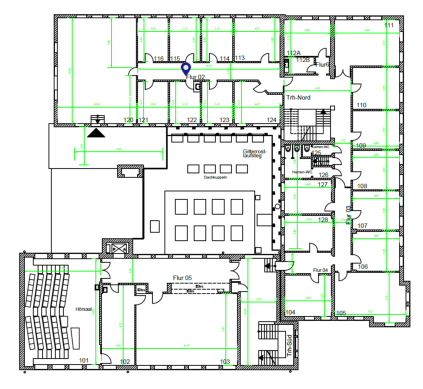

In [32]:
from src.plot import plot_position

print("[position détectée]  ")
print(f" M (x : {M[0]}, y : {M[1]})")

image = plot_position(
    M,
    None,
    "./images/pointeur.png",
    image=image_batiment,
    echelle=ECHELLE,
    showed=False,
)

plt.imshow(image)
plt.axis("off")
plt.show()